# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

* Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/
* All other resources - https://github.com/mrdbourke/pytorch-deep-learning
* Stuck? Ask a question - https://github.com/mrdbourke/pytorch-deep-learning/discussions


## 1. Make classification data and get it ready

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# Create cirlcels
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
print(f"first five samples of X : {X[:5]}")
print(f"first five samples of y : {y[:5]}")

first five samples of X : [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first five samples of y : [1 1 1 1 0]


In [ ]:
# It's a binary classification problem
import numpy as np
np.unique(y)

array([0, 1])

In [ ]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


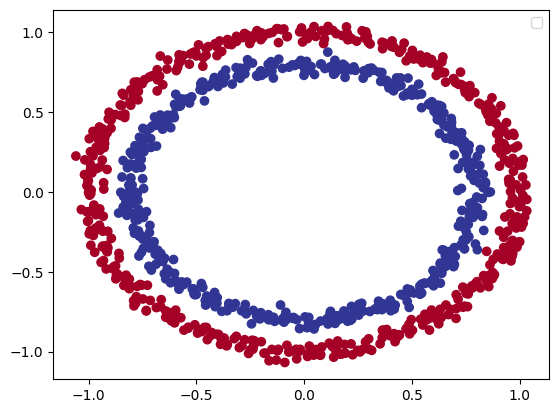

In [ ]:
# Visualise
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)
plt.legend()
plt.show()

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Sample input features: {X_sample}")
print(f"Sample target label: {y_sample}")

Sample input features: [0.75424625 0.23148074]
Sample target label: 1


### 1.2 Turn data into tensors and create train and test splits

In [ ]:
import torch
torch.__version__

'2.5.0+cu121'

In [ ]:
# Turn data into tensors
# note that default type for numpy is np.float64 whereas PyTorch is torch.float32
print(type(X), X.dtype)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print(X.dtype)

<class 'numpy.ndarray'> float64
torch.float32


In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: torch.Size([800, 2])
X_test shape: torch.Size([200, 2])


## 2. Building a Model

Let's build a model to classify our blue and red dots.

To do so, we want to:

1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses nn.Module (almost all models in PyTorch subclass nn.Module)
2. Create 2 nn.Linear() layers that are capable of handling the shapes of our data
3. Defines a forward() method that outlines the forward pass
4. Instantiates the model and sends it to the target device

In [ ]:
# 1. Construct a model that subclasses nn.Modlue

class CircleModelV0(nn.Module):
    def __init__(self):
        # 2. Create nn.Linear() layers
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)
    # 3.Define a forward method
    def forward(self,X):
        return self.layer2(self.layer1(X))

In [ ]:
# 4. Instantiates the model and sends it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Let's replicate the model above by using nn.Sequential()
# we can also use this nn.sequential in our model class as well
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5809, -0.5144],
                      [-0.5517, -0.5185],
                      [ 0.4591,  0.2890],
                      [-0.2202, -0.1004],
                      [ 0.2654, -0.6161]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6967, -0.4217,  0.2021,  0.2586, -0.3717], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3103, -0.4229,  0.4010,  0.3600, -0.3480]], device='cuda:0')),
             ('1.bias', tensor([-0.4084], device='cuda:0'))])

In [ ]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_1(X_test.to(device))
print(f"length of predictions :{ len(untrained_preds)}, Shape : {untrained_preds.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

length of predictions :200, Shape : torch.Size([200, 1])

First 10 predictions:
tensor([[ 0.0743],
        [ 0.1980],
        [-0.3001],
        [ 0.1806],
        [-0.3795],
        [-0.3033],
        [ 0.1080],
        [-0.0096],
        [-0.2961],
        [ 0.2054]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how wrong your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For some common choices of loss functions and optimizers - https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer

* For the loss function we're going to use torch.nn.BECWithLogitsLoss(), for more on what binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

* For a defintion on what a logit is in deep learning - https://stackoverflow.com/a/52111173/7900723

* For different optimizers see torch.optim

In [ ]:
# Setup the loss function

# Requires input to have gone through the sigmoid function already prior to input to BCE
loss_fn = nn.BCELoss()

# BCEWithLogitsLoss has sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss()

# we could also achieve BCEWithLogitsLoss() as follows
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )

In [ ]:
optimizer = torch.optim.SGD(params=model_1.parameters(),
                          lr=0.1)

In [ ]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw logits.

We can convert these logits into prediction probabilities by passing them to some kind of
activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the argmax().


In [ ]:
# View the first 5 outputs of the forward pass on the test data
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_test.to(device))[:5]
y_logits

tensor([[ 0.0743],
        [ 0.1980],
        [-0.3001],
        [ 0.1806],
        [-0.3795]], device='cuda:0')

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5186],
        [0.5493],
        [0.4255],
        [0.5450],
        [0.4063]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
with torch.inference_mode():
  y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 0., 1., 0.], device='cuda:0')

### 3.2 Building a training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_1.to(device)
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print out what's happening every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70040, Accuracy: 49.00% | Test Loss: 0.70949, Test Accuracy: 46.00%
Epoch: 10 | Loss: 0.69803, Accuracy: 49.75% | Test Loss: 0.70682, Test Accuracy: 45.50%
Epoch: 20 | Loss: 0.69664, Accuracy: 50.38% | Test Loss: 0.70479, Test Accuracy: 44.50%
Epoch: 30 | Loss: 0.69571, Accuracy: 50.50% | Test Loss: 0.70313, Test Accuracy: 45.00%
Epoch: 40 | Loss: 0.69505, Accuracy: 50.75% | Test Loss: 0.70176, Test Accuracy: 46.00%
Epoch: 50 | Loss: 0.69456, Accuracy: 50.50% | Test Loss: 0.70062, Test Accuracy: 46.50%
Epoch: 60 | Loss: 0.69419, Accuracy: 50.50% | Test Loss: 0.69969, Test Accuracy: 46.50%
Epoch: 70 | Loss: 0.69391, Accuracy: 50.38% | Test Loss: 0.69891, Test Accuracy: 47.00%
Epoch: 80 | Loss: 0.69370, Accuracy: 50.62% | Test Loss: 0.69827, Test Accuracy: 46.50%
Epoch: 90 | Loss: 0.69354, Accuracy: 50.62% | Test Loss: 0.69774, Test Accuracy: 47.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize!"

To do so, we're going to import a function called plot_decision_boundary() - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py


In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


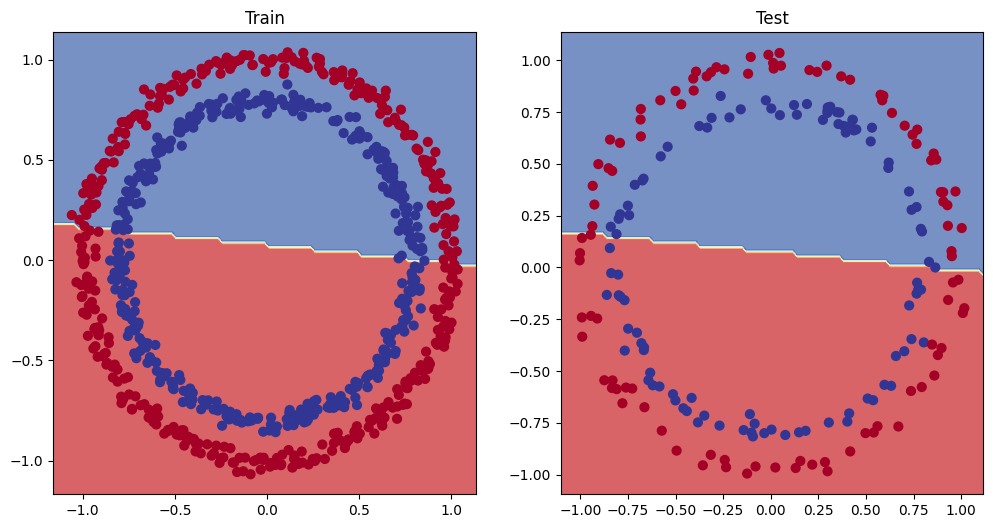

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

 ## 5.Improving a model (from a model perspective)

 * Add more layers - give the model more chances to learn about patterns in the data
 * Add more hidden units - go from 5 hidden units to 10 hidden units
 * Fit for longer
 * Changing/Adding the activation functions
 * Changing the learning rate
 * Changing the loss function

 These options are all from a model's perspective because they deal directly with the model, rather than the data.

 And because these options are all values we (as machine learning engineers and data scientists) can
 change, they are referred as `hyperparameters`.

 Let's try and improve our model by:

 * Adding more hidden units: 5 -> 10
 * Increase the number of layers: 2 -> 3
 * Increase the number of epochs: 100 -> 1000

In [ ]:
import torch
from torch import nn

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

class BiggerCircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.sequential = nn.Sequential(
        nn.Linear(in_features=2, out_features=16),
        nn.Linear(in_features=16, out_features=16),
        nn.Linear(in_features=16, out_features=1)
    )

  def forward(self,X):
    z = self.sequential(X)
    return z

In [ ]:
model_2 = BiggerCircleModel()
model_2.to(device)

BiggerCircleModel(
  (sequential): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
model_2.eval()
with torch.inference_mode():
  untrained_preds = model_2(X_test.to(device))
untrained_preds.shape

torch.Size([200, 1])

In [ ]:
# Create a loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)

In [ ]:
# accuracy function

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
# Untrained predictions
model_2.eval()
with torch.inference_mode():
  print(f"shape of X_test : {X_test.shape}")
  y_logits_untrained = model_2(X_test).squeeze()
  print(f"shape of y_logits_untrained : {y_logits_untrained.shape}")
y_preds_untrained = torch.round(nn.Sigmoid()(y_logits_untrained))
y_preds_untrained.shape

shape of X_test : torch.Size([200, 2])
shape of y_logits_untrained : torch.Size([200])


torch.Size([200])

In [ ]:
X_train.device

device(type='cuda', index=0)

In [ ]:
# Create training and testing loop
epochs = 1000

for epoch in range(epochs):
  model_2.train()
  # Forward pass
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(nn.Sigmoid()(y_logits))
  # Calculate loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
  # optimizer to zero
  optimizer.zero_grad()
  # backprop
  loss.backward()
  # otimizer step
  optimizer.step()

  # testing_loop
  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(nn.Sigmoid()(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69961, Accuracy: 54.00% | Test Loss: 0.69885, Test Accuracy: 47.50%
Epoch: 100 | Loss: 0.69298, Accuracy: 51.25% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 200 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%


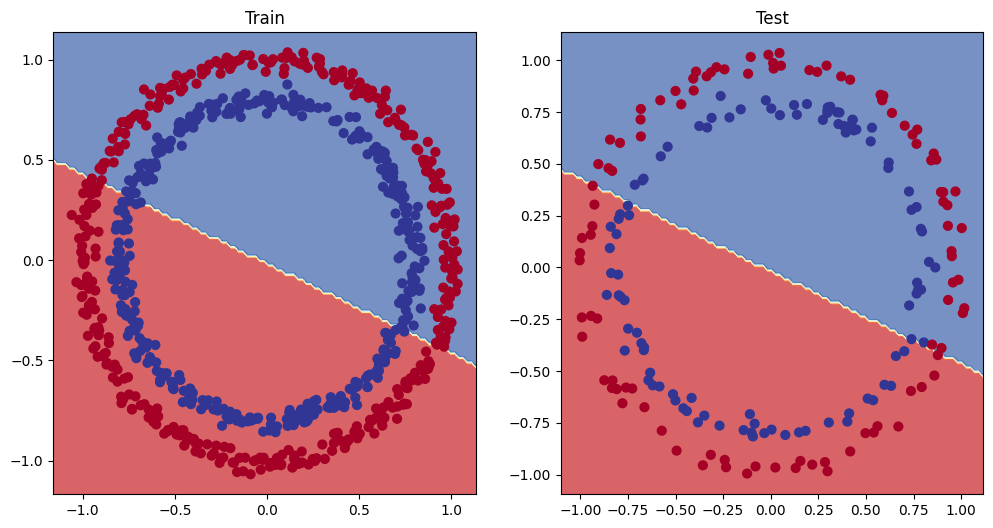

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

# 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

## 6.1 Recreating non-linear data (red and blue circles)

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000

X,y = make_circles(n_samples=1000, noise=0.03, random_state=42)

In [3]:
X.shape, y.shape

((1000, 2), (1000,))

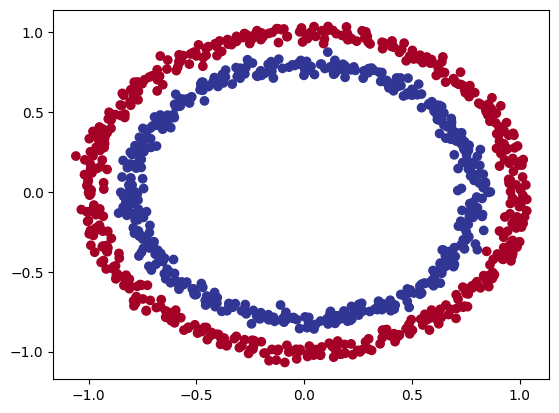

In [4]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# convert data to tensors

X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

X.device, y.device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [7]:
# Split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## 6.2 Building a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [8]:
from torch import nn

class MyNonLinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.ReLu = nn.ReLU()

  def forward(self, X):
    return self.layer3(self.ReLu(self.layer2(self.ReLu(self.layer1(X)))))

model_0 = MyNonLinearModel().to(device)
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.0890, -0.2833],
                      [-0.6976,  0.5802],
                      [-0.1198,  0.2829],
                      [ 0.1617, -0.3630],
                      [ 0.5741,  0.2644],
                      [ 0.4614,  0.6986],
                      [ 0.0604, -0.5208],
                      [ 0.3581, -0.5908],
                      [-0.2391,  0.3711],
                      [-0.5348, -0.1121]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.3777,  0.0935,  0.2505, -0.5917,  0.1134, -0.5054,  0.2374,  0.2844,
                       0.1467,  0.5751], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.1873, -0.0313,  0.0781, -0.0810, -0.0843, -0.1376,  0.0931,  0.0057,
                        0.2511,  0.2970],
                      [-0.2713, -0.2216,  0.1728, -0.2299,  0.1805,  0.2129,  0.2976, -0.2290,
                       -0.0971,  0.1930],
                      [-0.2915, -0.3053, 

In [9]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [10]:
# creating loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [11]:
# Training a model with non-linearity
epochs = 1000

for i in range(epochs):
  # Training loop
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred_train = torch.round(nn.Sigmoid()(y_logits))

  train_accuracy = round((100 * torch.sum(torch.eq(y_pred_train, y_train))/len(y_train)).item(), 2)
  train_loss = loss_fn(y_logits, y_train)

  optimizer.zero_grad()

  train_loss.backward()

  optimizer.step()

  # Testing loop
  model_0.eval()

  with torch.inference_mode():
    y_logits_test = model_0(X_test).squeeze()

    y_pred_test = torch.round(nn.Sigmoid()(y_logits_test))

    test_accuracy = round((100 * torch.sum(torch.eq(y_pred_test, y_test))/len(y_test)).item(), 2)
    test_loss = loss_fn(y_logits_test, y_test)

  if i % 100 == 0:
    print(f"Epoch: {i} | Loss: {train_loss:.5f}, Accuracy: {train_accuracy:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch: 0 | Loss: 0.69620, Accuracy: 50.00% | Test Loss: 0.69647, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69097, Accuracy: 54.12% | Test Loss: 0.69050, Test Accuracy: 51.00%
Epoch: 200 | Loss: 0.68765, Accuracy: 54.62% | Test Loss: 0.68714, Test Accuracy: 56.50%
Epoch: 300 | Loss: 0.68372, Accuracy: 66.12% | Test Loss: 0.68404, Test Accuracy: 63.50%
Epoch: 400 | Loss: 0.67709, Accuracy: 75.38% | Test Loss: 0.67870, Test Accuracy: 71.00%
Epoch: 500 | Loss: 0.66583, Accuracy: 91.00% | Test Loss: 0.66880, Test Accuracy: 86.00%
Epoch: 600 | Loss: 0.64613, Accuracy: 92.00% | Test Loss: 0.65066, Test Accuracy: 87.50%
Epoch: 700 | Loss: 0.61001, Accuracy: 93.25% | Test Loss: 0.61722, Test Accuracy: 90.50%
Epoch: 800 | Loss: 0.54222, Accuracy: 96.38% | Test Loss: 0.55299, Test Accuracy: 95.50%
Epoch: 900 | Loss: 0.42830, Accuracy: 98.88% | Test Loss: 0.44340, Test Accuracy: 98.00%


## 6.4 Evaluating a model trained with non-linear activation functions

In [12]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [13]:
# Makes predictions
model_0.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

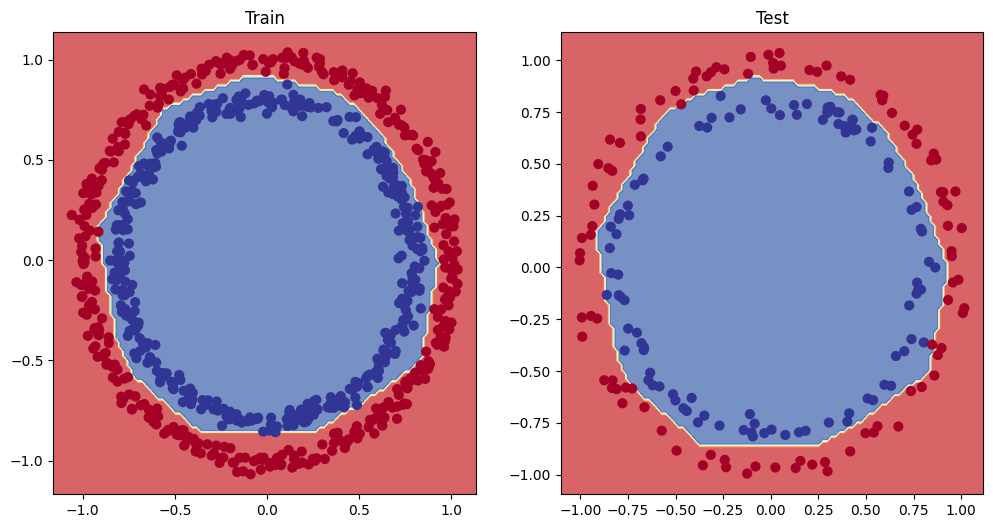

In [14]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test) # model_3 = has non-linearity

# 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.

In [15]:
import torch
import matplotlib.pyplot as plt
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

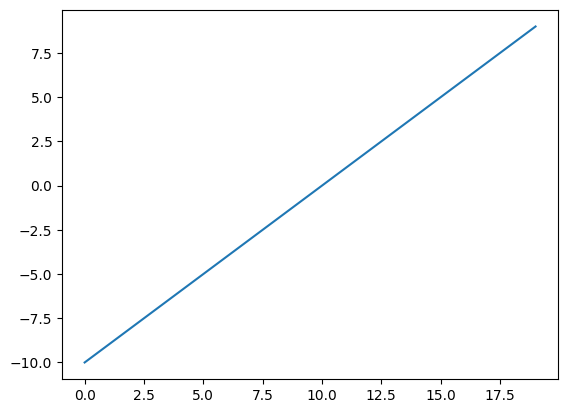

In [16]:
plt.plot(A)

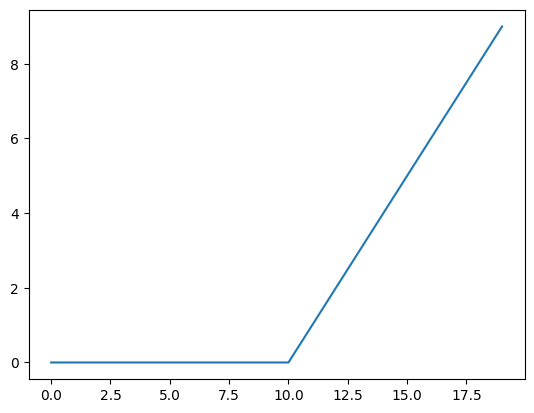

In [17]:
plt.plot(torch.relu(A))

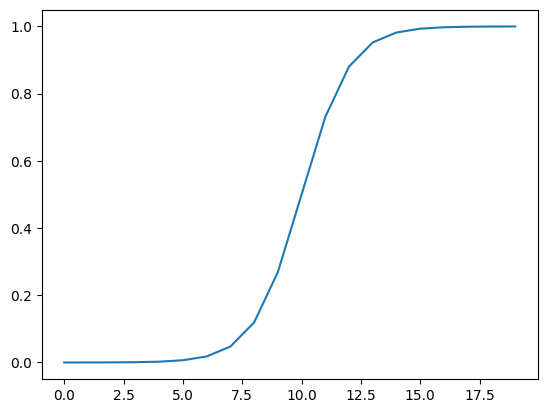

In [18]:
plt.plot(torch.sigmoid(A))

# 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

## 8.1 Creating a toy multi-class dataset

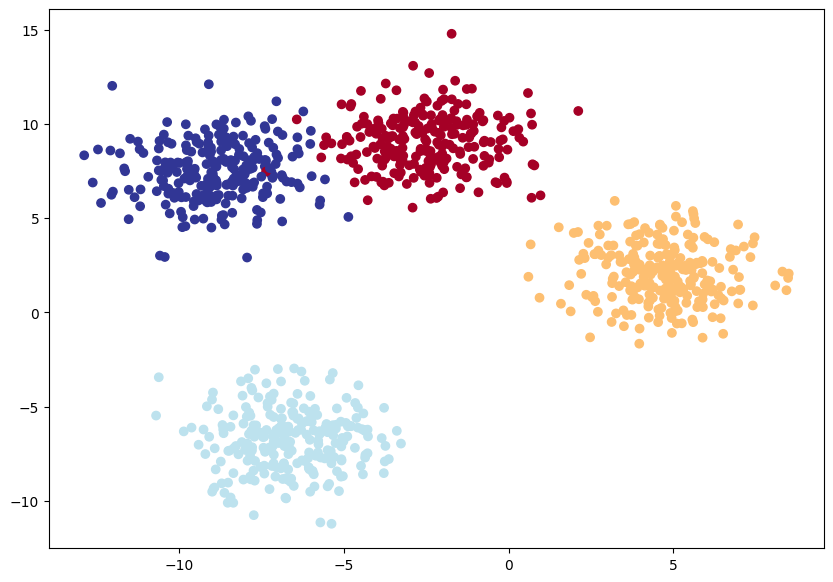

In [19]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
# NOTE THAT THE TARGET DATA TYPE HAS TO BE INT IN THIS CASE OR ELSE IT WILL GIVE ERROR LATER
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## 8.2 Building a multi-class classification model in PyTorch

In [20]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [21]:
from torch import nn
class BlobModel1(nn.Module):
  def __init__(self,input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, X):
    return self.linear_layer_stack(X)

model_0 = BlobModel1(input_features=2, output_features=4).to(device)
model_0.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.4824, -0.0945],
                      [-0.4052, -0.0744],
                      [ 0.5815, -0.0932],
                      [ 0.0775, -0.0200],
                      [-0.6179,  0.3318],
                      [ 0.3274, -0.5356],
                      [-0.1084,  0.6679],
                      [ 0.4595,  0.3207]], device='cuda:0')),
             ('linear_layer_stack.0.bias',
              tensor([-0.2241, -0.0319,  0.6787,  0.2597,  0.1317,  0.5882, -0.4485, -0.4528],
                     device='cuda:0')),
             ('linear_layer_stack.1.weight',
              tensor([[ 0.1652, -0.3471, -0.2242,  0.2560,  0.1954, -0.2559, -0.0181, -0.0722],
                      [ 0.1814,  0.2272, -0.3136,  0.0558,  0.0361, -0.1266,  0.2759, -0.1742],
                      [-0.0326, -0.1847,  0.2005, -0.2568,  0.0140,  0.2307,  0.3001, -0.0239],
                      [-0.3407, -0.0045, -0.2993, -0.3211, -0.3471,  0.2405,  0.1009, -0

In [22]:
X_blob_train.device

device(type='cpu')

In [23]:
X_blob_train = X_blob_train.to(device)
y_blob_train = y_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_test = y_blob_test.to(device)

In [24]:
X_blob_train.device, next(model_0.parameters()).device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [25]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3], device='cuda:0')

In [26]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [27]:
# Let's get raw output for our model(logits)
with torch.inference_mode():
  y_logits = model_0(X_blob_test)
y_logits[:5], y_logits.shape

(tensor([[-0.4229, -0.1837, -0.9783,  0.2804],
         [ 2.0080, -0.2199,  1.6889, -1.8976],
         [-0.1268, -1.3891,  0.7365,  1.3718],
         [-0.6720, -0.4714, -0.9144,  0.8327],
         [ 1.0973,  0.1910,  0.2298, -1.5307]], device='cuda:0'),
 torch.Size([200, 4]))

In [28]:
# convert our model's logits to prediction prob.
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5], y_pred_probs.shape

(tensor([[0.2056, 0.2611, 0.1180, 0.4153],
         [0.5392, 0.0581, 0.3919, 0.0109],
         [0.1230, 0.0348, 0.2917, 0.5505],
         [0.1332, 0.1627, 0.1045, 0.5996],
         [0.5274, 0.2131, 0.2215, 0.0381]], device='cuda:0'),
 torch.Size([200, 4]))

In [29]:
# Convert our model's prediction probabilities to prediction labels
y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
y_pred[:5], y_blob_test[:5]

(tensor([3, 0, 3, 3, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0], device='cuda:0'))

## 8.3 Createomg training and test loop

In [30]:
epochs = 100

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_blob_train)
  y_logits_softmax = torch.softmax(y_logits, dim=1)
  y_pred = torch.argmax(y_logits_softmax, dim=1)

  train_accuracy = round((100 * torch.sum(torch.eq(y_pred, y_blob_train))/len(y_blob_train)).item(), 2)

  optimizer.zero_grad()
  # the CELoss can take the y_logits directly instead of first applying softmax on it
  train_loss = loss(y_logits_softmax, y_blob_train)

  train_loss.backward()

  optimizer.step()

  # testing loop
  model_0.eval()
  with torch.inference_mode():
    y_logits_test = model_0(X_blob_test)
    y_logits_softmax_test = torch.softmax(y_logits_test, dim=1)
    y_pred_test = torch.argmax(y_logits_softmax_test, dim=1)

    test_accuracy = round((100 * torch.sum(torch.eq(y_pred_test, y_blob_test))/len(y_blob_test)).item(), 2)

    test_loss = loss(y_logits_softmax_test, y_blob_test)
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_accuracy:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_accuracy:.2f}%")



Epoch: 0 | Loss: 1.38625, Accuracy: 33.25% | Test Loss: 1.35036, Test Accuracy: 40.50%
Epoch: 10 | Loss: 1.06946, Accuracy: 75.38% | Test Loss: 1.08679, Test Accuracy: 70.50%
Epoch: 20 | Loss: 1.00151, Accuracy: 75.62% | Test Loss: 1.03117, Test Accuracy: 71.50%
Epoch: 30 | Loss: 0.83630, Accuracy: 98.88% | Test Loss: 0.83179, Test Accuracy: 99.00%
Epoch: 40 | Loss: 0.80385, Accuracy: 99.00% | Test Loss: 0.80036, Test Accuracy: 99.00%
Epoch: 50 | Loss: 0.78957, Accuracy: 99.00% | Test Loss: 0.78615, Test Accuracy: 99.50%
Epoch: 60 | Loss: 0.78155, Accuracy: 99.12% | Test Loss: 0.77809, Test Accuracy: 99.50%
Epoch: 70 | Loss: 0.77643, Accuracy: 99.00% | Test Loss: 0.77292, Test Accuracy: 99.50%
Epoch: 80 | Loss: 0.77288, Accuracy: 99.00% | Test Loss: 0.76934, Test Accuracy: 99.50%
Epoch: 90 | Loss: 0.77028, Accuracy: 99.00% | Test Loss: 0.76671, Test Accuracy: 99.50%


## 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [31]:
# Make predictions
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3268,   9.0477, -10.2713,  -6.6472],
        [  1.6454, -12.2850,   0.1766,   6.5490],
        [ -7.6958, -12.7558,  16.8116,   9.6631],
        [  1.7638,   6.5739,  -5.0795,  -4.4320],
        [  6.5202,   2.0618, -12.2781,  -3.2599],
        [  1.7125, -15.0974,   0.8108,   8.1608],
        [ -7.5685,  -9.7302,  15.7769,   7.8684],
        [  5.0689,  -1.7160,  -8.7022,  -0.6260],
        [ -8.4648, -17.7499,  19.5073,  12.7954],
        [  5.4908,  -0.3267,  -9.8196,  -1.5606]], device='cuda:0')

In [32]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[8.8290e-03, 9.9117e-01, 4.0366e-09, 1.5134e-07],
        [7.3528e-03, 6.5544e-09, 1.6926e-03, 9.9095e-01],
        [2.2712e-11, 1.4411e-13, 9.9921e-01, 7.8545e-04],
        [8.0810e-03, 9.9189e-01, 8.6194e-06, 1.6469e-05],
        [9.8850e-01, 1.1447e-02, 6.7758e-09, 5.5917e-05],
        [1.5796e-03, 7.9090e-11, 6.4114e-04, 9.9778e-01],
        [7.2621e-11, 8.3609e-12, 9.9963e-01, 3.6748e-04],
        [9.9553e-01, 1.1257e-03, 1.0407e-06, 3.3479e-03],
        [7.1011e-13, 6.5900e-17, 9.9879e-01, 1.2149e-03],
        [9.9617e-01, 2.9637e-03, 2.2343e-07, 8.6292e-04]], device='cuda:0')

In [33]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [34]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


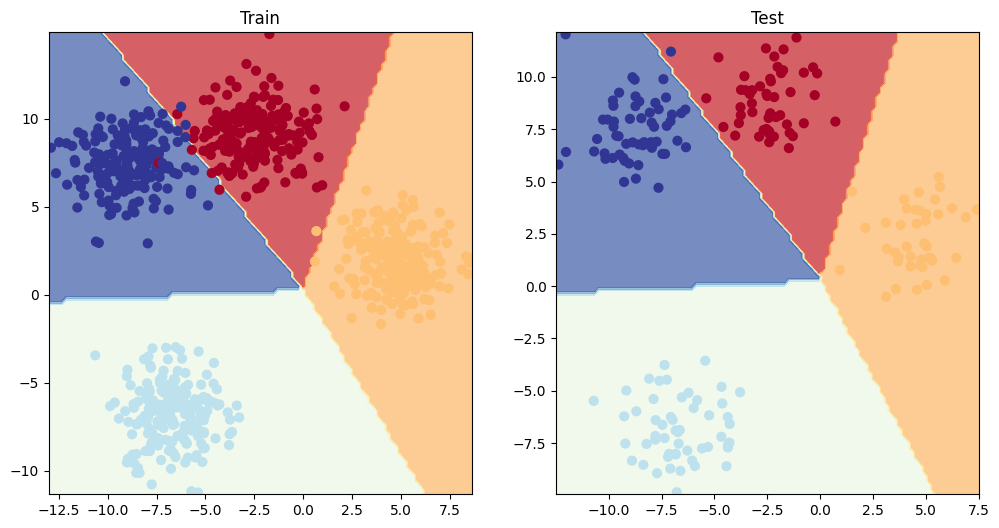

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_blob_test, y_blob_test)

# 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

See this article for when to use precision/recall - https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want access to a lot of PyTorch metrics, see TorchMetrics - https://torchmetrics.readthedocs.io/en/latest/

In [37]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 25.8 MB/s eta 0:00:00


In [41]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculuate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [42]:
torchmetric_accuracy.device


device(type='cuda', index=0)

### Exercises & Extra-curriculum
See exercises and extra-curriculum here: https://www.learnpytorch.io/02_pytorch_classification/#exercises